# Bandwidths 

Based on kde_tutorial from https://notebooks.gesis.org/binder/jupyter/user/saint-germain-p-ation_synthesis-uu00810x/tree/prep

The data trataiment:

In [1]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
dn=pd.read_csv('proc_no_pert.csv',index_col=None) #without pertubtations 
dn["gia"]=dn.ngi>0
dl=pd.read_csv('proc_lo_pert.csv',index_col=None) #with low pertubtations 
dl["gia"]=dl.ngi>0
dh=pd.read_csv('proc_hi_pert.csv',index_col=None) #with high pertubtations 
dh["gia"]=dh.ngi>0

In [5]:
#Terrestrial
dnt=dn[~dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]] # high pertubtations 

#Giant 
dng=dn[dn["gia"]]  # without pertubtations 
dlg=dl[dl["gia"]]  # low pertubtations 
dhg=dh[dh["gia"]]  # high without pertubtations 

In [6]:
print("***************************************")
print("Total systems                  : "+str(len(dn)))
print("***************************************")
print("Total planets - no             : "+str(dn.nplanets.sum().astype(int)))
print("Giant planets - no             : "+str(dn.ngi.sum().astype(int)))
print("Systems with giant planets - no: "+str(dn.gia.sum()))
print("***************************************")

print("Total planets - lo             : "+str(dl.nplanets.sum().astype(int)))
print("Giant planets - lo             : "+str(dl.ngi.sum().astype(int)))
print("Systems with giant planets - lo: "+str(dl.gia.sum()))
print("***************************************")
print("Total planets - hi             : "+str(dh.nplanets.sum().astype(int)))
print("Giant planets - hi             : "+str(dh.ngi.sum().astype(int)))
print("Systems with giant planets - hi: "+str(dh.gia.sum()))

***************************************
Total systems                  : 1221
***************************************
Total planets - no             : 15887
Giant planets - no             : 330
Systems with giant planets - no: 268
***************************************
Total planets - lo             : 15732
Giant planets - lo             : 374
Systems with giant planets - lo: 306
***************************************
Total planets - hi             : 15441
Giant planets - hi             : 388
Systems with giant planets - hi: 309


Some important variables: 

In [7]:
#log_10 of mass efficiency and center of mass
#log_10 mass efficiency giant and terrestrial 
dng['logeff']=np.log10(dng.massefficiency)
dlg['logeff']=np.log10(dlg.massefficiency)
dhg['logeff']=np.log10(dhg.massefficiency)
dnt['logeff']=np.log10(dnt.massefficiency)
dlt['logeff']=np.log10(dlt.massefficiency)
dht['logeff']=np.log10(dht.massefficiency)#
#log_10 total mass efficiency
dn['logeff']=np.log10(dn.massefficiency)
dl['logeff']=np.log10(dl.massefficiency)
dh['logeff']=np.log10(dh.massefficiency)

#log_10 total com
dn['logcom']=np.log10(dn.com)
dl['logcom']=np.log10(dl.com)
dh['logcom']=np.log10(dh.com)

#log_10 com giant and terrestrial 
dng['logcom']=np.log10(dng.com)
dlg['logcom']=np.log10(dlg.com)
dhg['logcom']=np.log10(dhg.com)
dnt['logcom']=np.log10(dnt.com)
dlt['logcom']=np.log10(dlt.com)
dht['logcom']=np.log10(dht.com)

In [8]:
dng.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
0,0,3.0,1.081461,10.0,10770.309627,0.576981,90.793337,0.056,29.539343,0.880114,0.328146,1644710.625,8.421395,4.0,12.004623,0.0,True,-0.238839,0.034011
2,2,6.0,0.110789,12.0,2422.342359,0.060559,75.740878,0.120,47.343380,0.861595,0.021273,1790533.125,4.412694,1.0,29.771089,0.0,True,-1.217824,-0.955504
4,4,13.0,0.172211,13.0,2905.457535,0.051273,178.830700,0.170,36.672222,1.206445,-0.174039,3956707.500,3.998513,1.0,14.220447,0.0,True,-1.290113,-0.763939
16,16,31.0,4.377862,11.0,41.578462,0.001299,86.546084,0.096,39.613728,0.993549,-0.031508,1439538.875,5.991912,1.0,17.716253,0.0,True,-2.886282,0.641262
23,23,40.0,2.144859,13.0,181.982608,0.006578,57.698437,0.083,45.111870,1.037112,0.039315,2374519.750,7.413428,1.0,14.782324,0.0,True,-2.181927,0.331399


## Bandwidth problem

an example with kernel density

In [9]:
# an example with kernel density
x=dng.ngi
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=50) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

# other example with gaussian_kde method. 
from scipy.stats import gaussian_kde
kde = gaussian_kde(x)
f = kde.covariance_factor()
bw = f * x.std()
print("bw g_kde: "+str(bw))

{'bandwidth': 0.4}
bw g_kde: 0.17399675736725956


A comparison plot

(array([2.71144279, 0.        , 0.        , 0.49751244, 0.        ,
        0.        , 0.09950249, 0.        , 0.        , 0.02487562]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

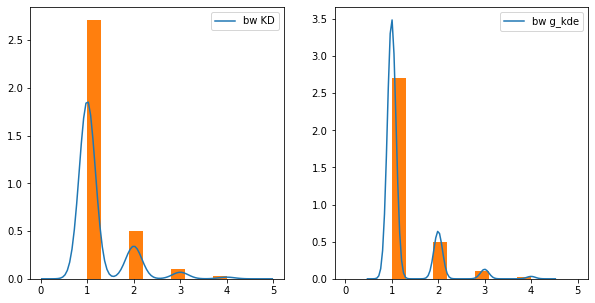

In [10]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.kdeplot(dng.ngi,bw=.32688, ax=axes[0], label="bw KD"); axes[0].hist(dng.ngi, density=True)
sns.kdeplot(dng.ngi,bw=bw, ax=axes[1],label="bw g_kde"); axes[1].hist(dng.ngi, density=True)

Now, a comparative example. 

0.06861681279645619 0.07616826615220967


Text(0.5, 0.98, '  variable sdg.logeff')

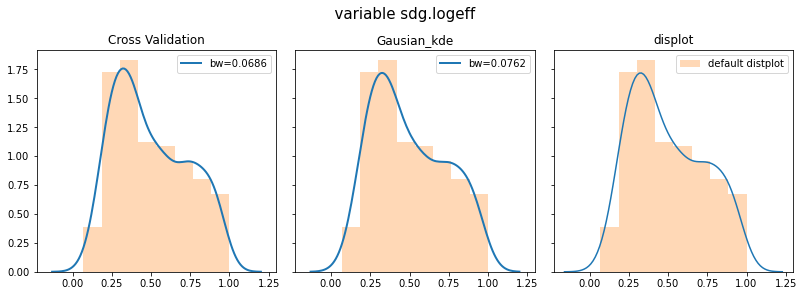

In [11]:
variable = dng.logeff/dng.logeff.min()
x_grid = np.around(np.arange(variable.min()-.2,variable.max()+.2,0.001),2)

#===CV:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(variable.min(),variable.max(),40)},
                    cv=20) # 20-fold cross-validation
grid.fit(variable[:, None])
kde_CV = grid.best_estimator_
pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None])) #kde.score() returns the log_10 of pdf

#===Gaussian_KDE:
kde_G = gaussian_kde(variable)
f = kde_G.covariance_factor()
bw_kde = f * variable.std()
pdf_kde = kde_G.evaluate(x_grid)

print(kde_CV.bandwidth,bw_kde)

#Comparative plot
fig, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True,
                      sharex=True, sharey=True)
#-------CV_plot:
ax[0].plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
ax[0].hist(variable,8,density=True, alpha=.3)
ax[0].legend(loc="upper right")
ax[0].set_title("Cross Validation")
#-------kde_plot:
ax[1].plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_kde)
ax[1].hist(variable,8,density=True, alpha=.3)
ax[1].legend(loc="upper right")
ax[1].set_title("Gausian_kde")
#-------sns_plot:
sns.distplot(variable,  ax=ax[2], axlabel=False,
             hist_kws={"alpha": .3, "color": 'C1'}, label='default distplot') 
ax[2].legend(loc="upper right")
ax[2].set_title("displot")
#-------
fig.suptitle("  variable sdg.logeff", fontsize=15, horizontalalignment='center')

Now we introduce a new funtoion that obtain the bandwidths through `Gaussian_kde` and `CrossValidation`

In [12]:
#The variable is a column from dataFrames: 'dng','dlg','dhg','dnt','dlt','dht','dn','dl','dh'
def bw_optimal(variable, name, plot=False):

    m=.2; dvariable=0.01; deciamls=2
    
    x = variable/variable.min() 
    x_grid = np.around(np.arange(x.min()-m,x.max()+m,dvariable),deciamls)
    norm, size, cv = 10, 30, 30 # 30-fold cross-validation     
        
    #-------------With CrossValidation:
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(x.min(),x.max()/norm,size)}, cv=cv) # max-min (grid)
    grid.fit(x[:, None])
    kde_CV = grid.best_estimator_
    bw_CV  = list(grid.best_params_.values())[0]
    pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None]))
    
    #-------------Gaussian_KDE:
    kde_G = gaussian_kde(x)
    f = kde.covariance_factor()
    bw_KDE =  f * x.std()
    pdf_kde = kde_G.evaluate(x_grid)
    
    #---------Comparative plot: 
    if plot == True: 
        fig, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True, sharex=True, sharey=True)
        #-------CV_plot:
        ax[0].plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
        ax[0].hist(x,8,density=True, alpha=.3)
        ax[0].legend(loc="upper right")
        ax[0].set_title("Cross Validation")
        #-------kde_plot:
        ax[1].plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_kde)
        ax[1].hist(x,8,density=True, alpha=.3)
        ax[1].legend(loc="upper right")
        ax[1].set_title("Gausian_kde")
        #-------sns_plot:
        sns.distplot(x,  ax=ax[2], axlabel=False, bins=8,
                     hist_kws={"alpha": .3, "color": 'C1'}, 
                     label='default distplot') 
        ax[2].legend(loc="upper right")
        ax[2].set_title("displot")
        #---------------
        fig.suptitle("variable: "+name, 
                     fontsize=15, horizontalalignment='center')
        plt.show()
    return [bw_CV, bw_KDE]

Then, the optimal bandwidhts came from `bw_optimal` function

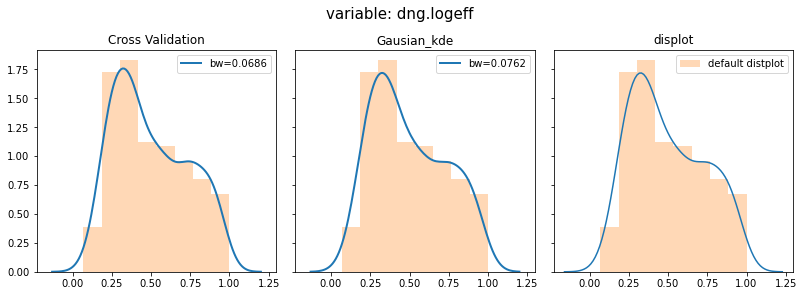

In [13]:
dng_logeff = bw_optimal(dng.logeff,name="dng.logeff", plot=True)

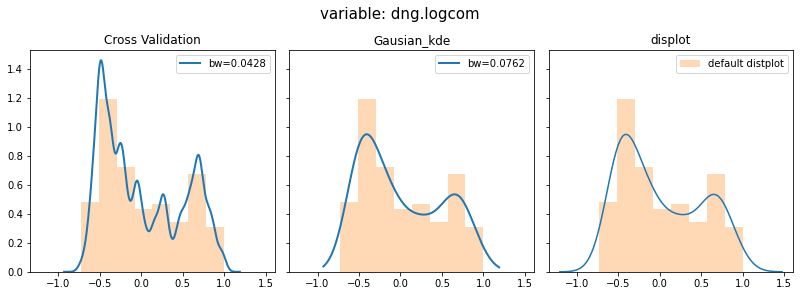

In [14]:
dng_logcom = bw_optimal(dng.logcom, name="dng.logcom", plot=True)

Now, for all the variables

dng.logeff


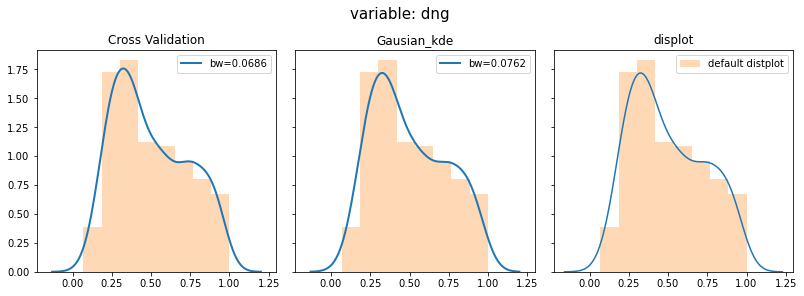

dlg.logeff


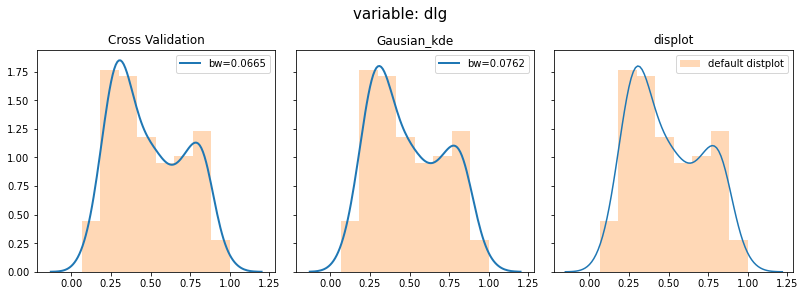

dhg.logeff


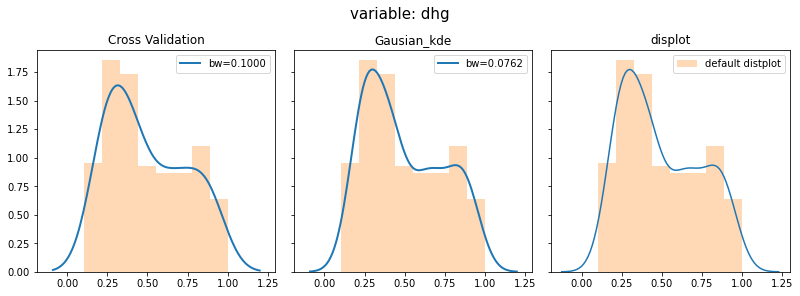

dnt.logeff


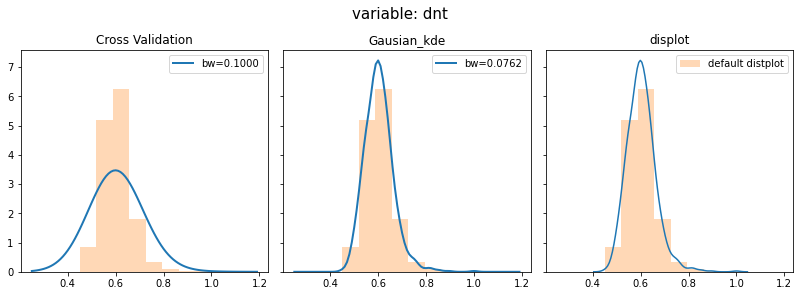

dlt.logeff


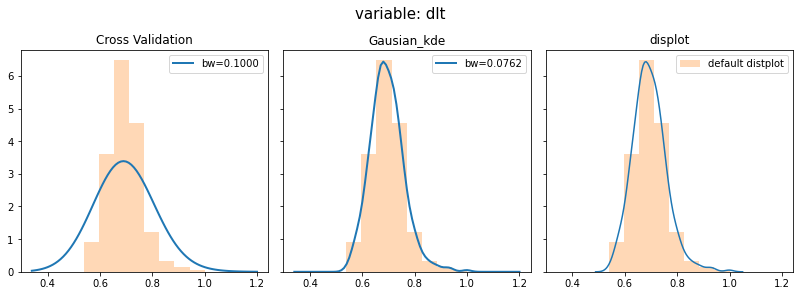

dht.logeff


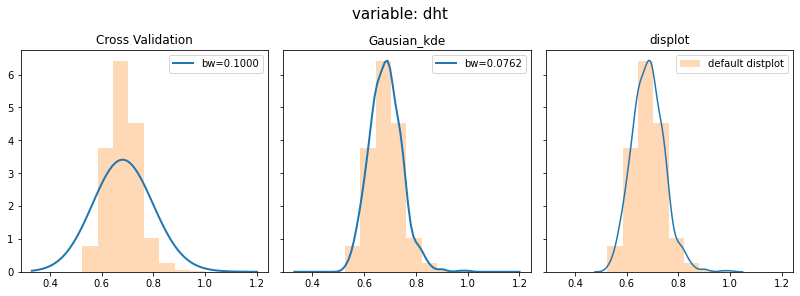

dn.logeff


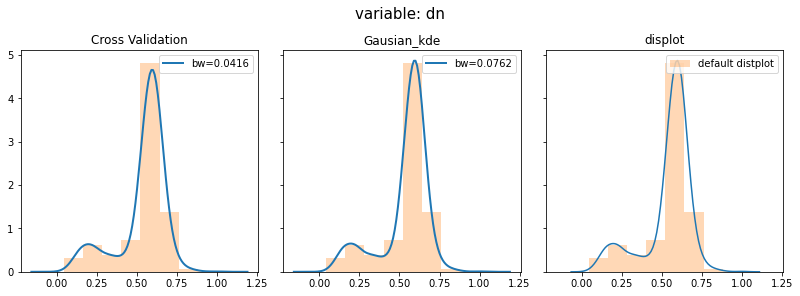

dl.logeff


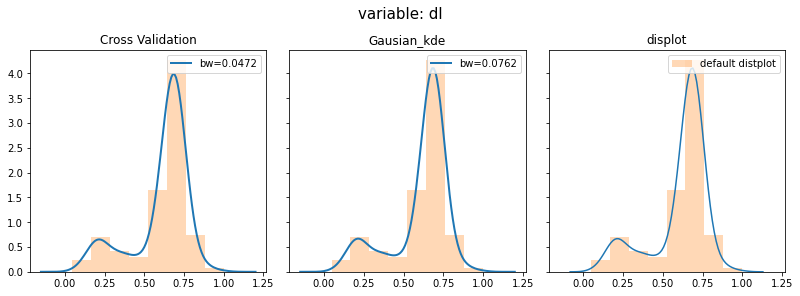

dh.logeff


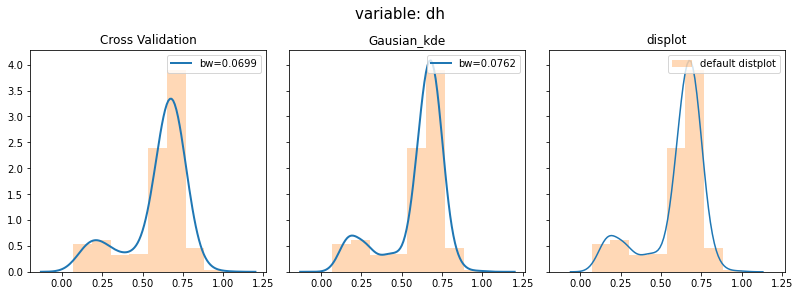

In [15]:
#%%time
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
names       = ["dng","dlg","dhg","dnt","dlt","dht","dn","dl","dh"]
opt_bw_eff  = [] 
#opt_bw_logcom  = [] 

for index,variable in enumerate(x_variables):
    print(names[index]+"."+str(variable.logeff.name))
    bw = bw_optimal(variable.logeff, names[index], plot=True)
    opt_bw_eff.append(bw)


dng.logcom


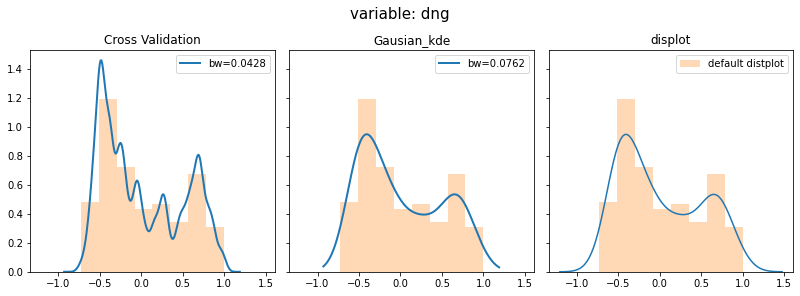

dlg.logcom


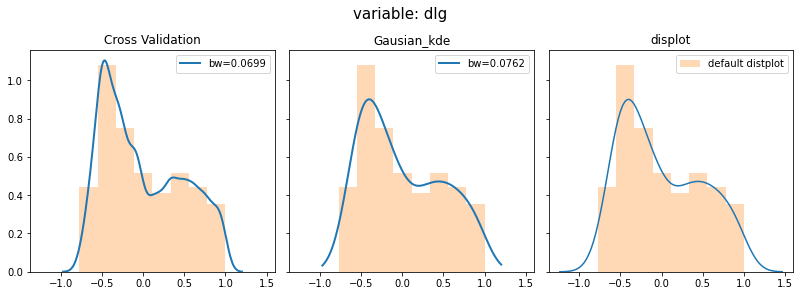

dhg.logcom


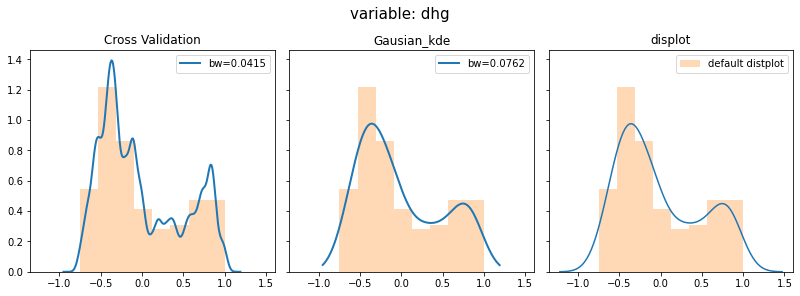

dnt.logcom


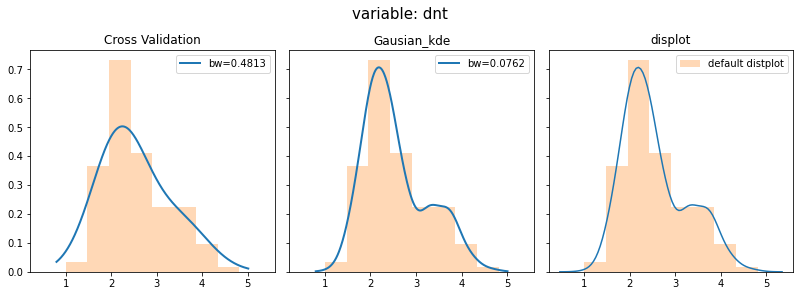

dlt.logcom


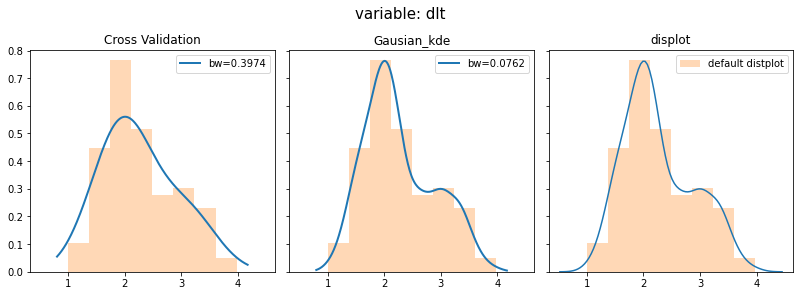

dht.logcom


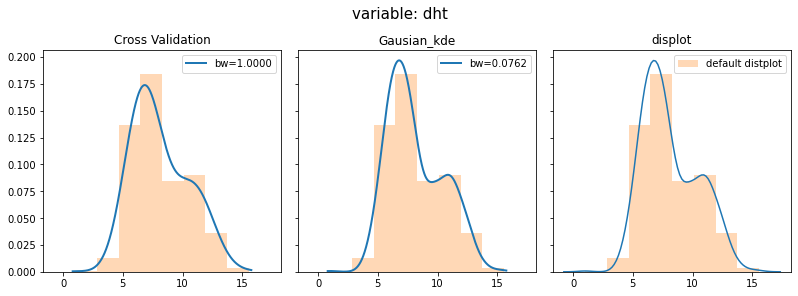

dn.logcom


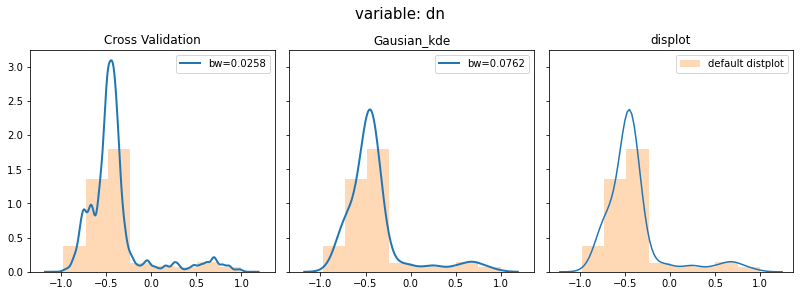

dl.logcom


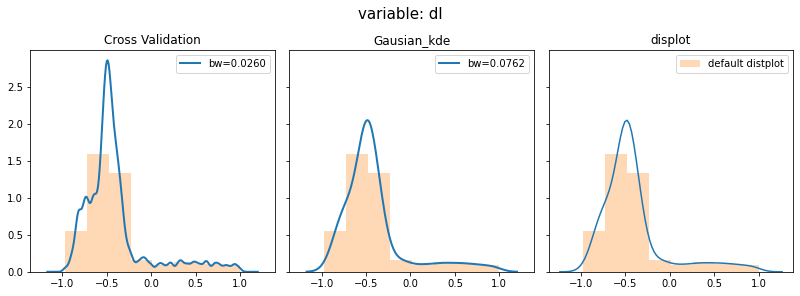

dh.logcom


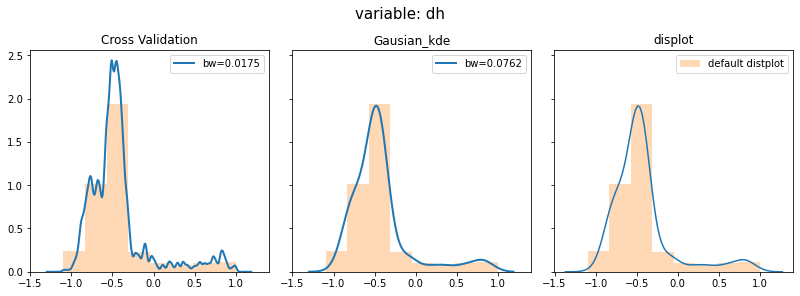

In [16]:
#%%time
opt_bw_com      = [] 
#opt_bw_logcom  = [] 

for index,variable in enumerate(x_variables):
    print(names[index]+"."+str(variable.logcom.name))
    bw = bw_optimal(variable.logcom, names[index], plot=True)
    opt_bw_com.append(bw)

The comparative plot for the log_10 of efficiency

## Bandwiths for  2D, 3D and mode dimensions

### 2D Example
For 2d, we have the function:

In [17]:
def uni_kde(x,y,tickno=5,nlev=30):
    
    x_grid=np.around(np.arange(x.min(),x.max(),0.1),2)
    y_grid=np.linspace(y.min(),y.max(),len(x_grid))
    conv=(x.max()-x.min())/(y.max()-y.min())
    yori=y
    y=y*conv
    y_grid=y_grid*conv
    
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
    
    grid.fit(np.vstack([x,y]).T)
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
  
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    levels = np.linspace(0, pdf2d.max(), nlev)
    plt.contourf(X, Y, pdf2d, levels=levels, cmap=plt.cm.Reds)
    
    old_ticks=np.linspace(y.max(), y.min(), tickno)
    major_ticks = 10**np.linspace(yori.max(), yori.min(), tickno)
    myticks=[]
    for i in major_ticks:
        myticks+=["%.e"%i]
    e=plt.yticks(old_ticks,myticks) 

{'bandwidth': 0.09996864449290914}


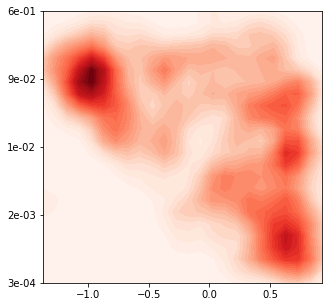

In [18]:
uni_kde(dng.logcom,dng.logeff)

### 3D example

In [19]:
from mpl_toolkits import mplot3d
#---------------------Data:
x = dng.logeff/dng.logeff.min()
y = dng.logcom#/dng.logcom.min()
z = dng.nplanets

data = np.vstack((x,y,z)).T

#---------------------Grid:
x_grid=np.around(np.arange(x.min(),x.max(),0.05),2)
y_grid=np.linspace(y.min(),y.max(),len(x_grid))
z_grid=np.linspace(z.min(),z.max(),len(x_grid))

X,Y,Z = np.meshgrid(x_grid, y_grid, z_grid)
xyz   = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

#----------------------CV:

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
grid.fit(data)

    
kde3d = grid.best_estimator_
pdf3d = np.exp(kde3d.score_samples(xyz)).reshape(X.shape) #get the pdf

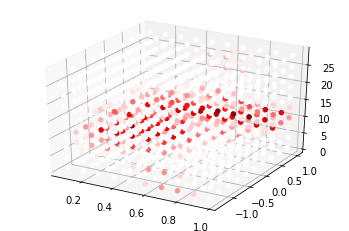

In [23]:
density = pdf3d.ravel()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = X.ravel(), Y.ravel(), Z.ravel()
ax.scatter(x, y, z, c=density, alpha=1, cmap= 'seismic',
           vmin=-np.abs(np.max(density)),vmax=np.abs(np.max(density)))

In [24]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=density.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=25, # needs to be a large number for good volume rendering
    ))
fig.show()

In [22]:
#-------------Gaussian_KDE:
'''
kde_G = gaussian_kde(data)
f = kde.covariance_factor()
bw_KDE =  f * data.std()
pdf3_kde = kde_G.evaluate(xyz)
pdf3_kde = kde_G.evaluate()
'''

'\nkde_G = gaussian_kde(data)\nf = kde.covariance_factor()\nbw_KDE =  f * data.std()\npdf3_kde = kde_G.evaluate(xyz)\npdf3_kde = kde_G.evaluate()\n'